In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# -------- Insert your code here -------- #
filename_save_out = "Losses_out"
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    y = np.zeros((Nout, len(rho)))
    w = np.zeros((Nout, K))
    z = np.random.randn(K, 1)
    Losses_out = np.zeros((Nout,K))
    for s in range(0, Nout):
        y_n = np.random.randn(len(rho), 1)
        y[s, :] = np.dot(sqrt_rho, y_n).reshape(-1, )
        # -------- Insert your code here -------- #
        for k in range(K):
        # -------- Insert your code here -------- %
        # Calculated out-of-sample losses (100000 x 100)
            cd = int(driver[k])
            w[s,k] = beta[k] * y[s,cd] + np.sqrt(1-beta[k]**2) * z[k]
            credit_oos = np.append(w[s,k], CS_Bdry[k,:])
            credit_oos = np.sort(credit_oos)
            credit_state = np.argwhere(credit_oos == w[s,k])
            Losses_out[s,k] = exposure[k, credit_state]
        # Calculated out-of-sample losses (100000 x 100)
    Losses_out = scipy.sparse.csr_matrix(Losses_out)
    scipy.sparse.save_npz(filename_save_out + '.npz', Losses_out)
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))



======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [2]:
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #                   
        VaRout[portN, q] = np.sort(np.dot(Losses_out.toarray(), x0[portN]))[int(math.ceil(Nout * alf))-1]
        VaRinN[portN, q] = np.mean(np.sort(np.dot(Losses_out.toarray(), x0[portN]))) + scs.norm.ppf(alf) * np.std(np.sort(np.dot(Losses_out.toarray(), x0[portN])))
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(np.sort(np.dot(Losses_out.toarray(), x0[portN]))[int(math.ceil(Nout * alf)):]))
        CVaRinN[portN, q] = np.mean(np.sort(np.dot(Losses_out.toarray(), x0[portN]))) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(np.sort(np.dot(Losses_out.toarray(), x0[portN])))
                                                            
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}
portf_loss_inMC1 = {}
portf_loss_inMC2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [3]:

for tr in range(1, N_trials+1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    i = 0
    w_mc1 = np.zeros((int(math.ceil(Nin / Ns)), Ns, K))
    y_mc1 = np.zeros((int(math.ceil(Nin / Ns)), len(rho)))
    Losses_mc1_p = np.zeros((int(np.ceil(Nin / Ns)), Ns, K))              
    Losses_mc1 = np.zeros((Nin, K))
    for s in range(0, np.int(np.ceil(Nin / Ns))): # systemic scenarios
        # -------- Insert your code here -------- #
        credit_state = np.zeros((Nout,K))
        y_n_mc1 = np.random.randn(len(rho),1)
        y_mc1[s,:] = np.dot(sqrt_rho, y_n_mc1).reshape(-1,)
        for si in range(0, Ns): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_mc1 = np.random.randn(K,1)
            for k in range(K):                           
                cd1 = int(driver[k])
                w_mc1[s, si, k] = beta[k] * y_mc1[s, cd1] + np.sqrt(1-beta[k]**2) * z_mc1[k]
                credit_mc1 = np.append(w_mc1[s,si][k], CS_Bdry[k,:])
                credit_level_mc1 = np.sort(credit_mc1)
                credit_state = np.argwhere(credit_level_mc1 == w_mc1[s,si][k])
                Losses_mc1_p[s,si,k] = exposure[k,credit_state]
            Losses_mc1[i,:] = Losses_mc1_p[s,si]
            i += 1
    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    w_mc2 = np.zeros((Nin, K))
    y_mc2 = np.zeros((Nin, len(rho)))
    Losses_mc2 = np.zeros((Nin, K))
    z_mc2 = np.random.randn(K,1)
    for s in range(0, Nin): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        credit_state = np.zeros((Nout,K))
        y_n_mc2 = np.random.randn(len(rho),1)
        y_mc2[s,:] = np.dot(sqrt_rho, y_n_mc2).reshape(-1,)
        for k in range(K):
            cd2 = int(driver[k])
            w_mc2[s,k] = beta[k] * y_mc2[s,cd2] + np.sqrt(1-beta[k]**2) * z_mc2[k]
            credit_mc2 = np.append(w_mc2[s,k], CS_Bdry[k,:])
            credit_level_mc2 = np.sort(credit_mc2)
            credit_state = np.argwhere(credit_level_mc2 == w_mc2[s,k])
            Losses_mc2[s,k] = exposure[k,credit_state]
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2


    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_mc1,x0[portN])) #...
            portf_loss_inMC2 = np.sort(np.dot(Losses_mc2,x0[portN])) #...
            mu_MC1 = np.mean(Losses_mc1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_mc1, rowvar=False)
            mu_MC2 = np.mean(Losses_mc2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_mc2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1.T, x0[portN]) #...
            sigma_p_MC1 = np.std(portf_loss_inMC1) #...
            mu_p_MC2 = np.dot(mu_MC2.T, x0[portN]) #...
            sigma_p_MC2 = np.std(portf_loss_inMC2) #...
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin*alf))-1] #...
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin*alf))-1] #...
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf)*sigma_p_MC1 #...
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf)*sigma_p_MC2 #...
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr-1] + np.sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):])) #...
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr-1] + np.sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))#...
            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf))/(1-alf))*sigma_p_MC1 #...
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf))/(1-alf))*sigma_p_MC2 #...
            
            

In [4]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))

# Plot results
# Figure (1):
# -------- Insert your code here -------- #

# Figure (2):
# -------- Insert your code here -------- #


Portfolio 1:

Out-of-sample: VaR 99.0% = $19804166.12, CVaR 99.0% = $33398560.98
In-sample MC1: VaR 99.0% = $38660621.54, CVaR 99.0% = $46380009.61
In-sample MC2: VaR 99.0% = $29041180.45, CVaR 99.0% = $35935900.16
In-sample No: VaR 99.0% = $10493529.27, CVaR 99.0% = $11877809.27
In-sample N1: VaR 99.0% = $26849030.34, CVaR 99.0% = $29832236.22
In-sample N2: VaR 99.0% = $22630117.06, CVaR 99.0% = $24949132.63

Out-of-sample: VaR 99.9% = $44157007.86, CVaR 99.9% = $53665929.53
In-sample MC1: VaR 99.9% = $55941932.47, CVaR 99.9% = $62824328.86
In-sample MC2: VaR 99.9% = $44380246.70, CVaR 99.9% = $51856638.50
In-sample No: VaR 99.9% = $13614021.90, CVaR 99.9% = $14744994.86
In-sample N1: VaR 99.9% = $33573877.91, CVaR 99.9% = $36011192.03
In-sample N2: VaR 99.9% = $27857723.50, CVaR 99.9% = $29752386.37


Portfolio 2:

Out-of-sample: VaR 99.0% = $17476284.11, CVaR 99.0% = $23155883.03
In-sample MC1: VaR 99.0% = $27873117.50, CVaR 99.0% = $33843011.26
In-sample MC2: VaR 99.0% = $25811061

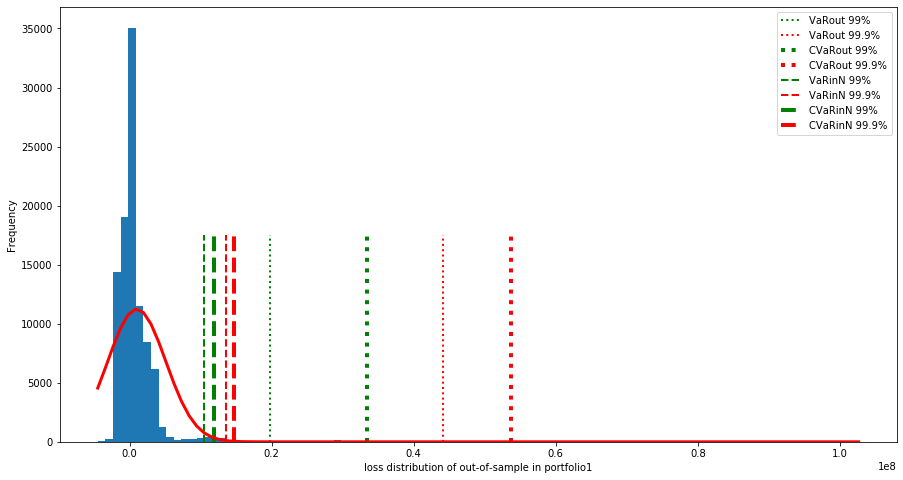

In [11]:
# Portfolio 1 out of sample
plt.figure(figsize=(15,8))
frequencyCounts, binLocations, patches = plt.hist(np.sort(np.dot(Losses_out.toarray(), x0[0])), 100)
normf = (1 / (np.std(np.sort(np.dot(Losses_out.toarray(), x0[0]))) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.sort(np.dot(Losses_out.toarray(), x0[0])))) / np.std(np.sort(np.dot(Losses_out.toarray(), x0[0])))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle=':')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle=':')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle=':')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle=':')
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle='--')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='--')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle='--')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle='--')
plt.legend(["VaRout 99%", "VaRout 99.9%", "CVaRout 99%", "CVaRout 99.9%", "VaRinN 99%", "VaRinN 99.9%", "CVaRinN 99%", "CVaRinN 99.9%"])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('loss distribution of out-of-sample in portfolio1')
plt.ylabel('Frequency')
plt.draw()

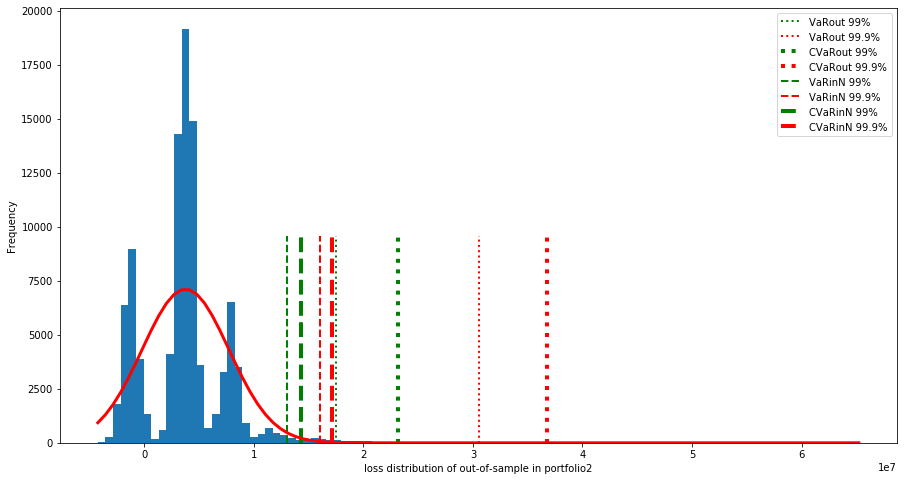

In [6]:
# Portfolio 2 out of sample
plt.figure(figsize=(15,8))
frequencyCounts, binLocations, patches = plt.hist(np.sort(np.dot(Losses_out.toarray(), x0[1])), 100)
normf = (1 / (np.std(np.sort(np.dot(Losses_out.toarray(), x0[1]))) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.sort(np.dot(Losses_out.toarray(), x0[1])))) / np.std(np.sort(np.dot(Losses_out.toarray(), x0[1])))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle=':')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle=':')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle=':')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle=':')
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle='--')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='--')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle='--')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle='--')
plt.legend(["VaRout 99%", "VaRout 99.9%", "CVaRout 99%", "CVaRout 99.9%", "VaRinN 99%", "VaRinN 99.9%", "CVaRinN 99%", "CVaRinN 99.9%"])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('loss distribution of out-of-sample in portfolio2')
plt.ylabel('Frequency')
plt.draw()

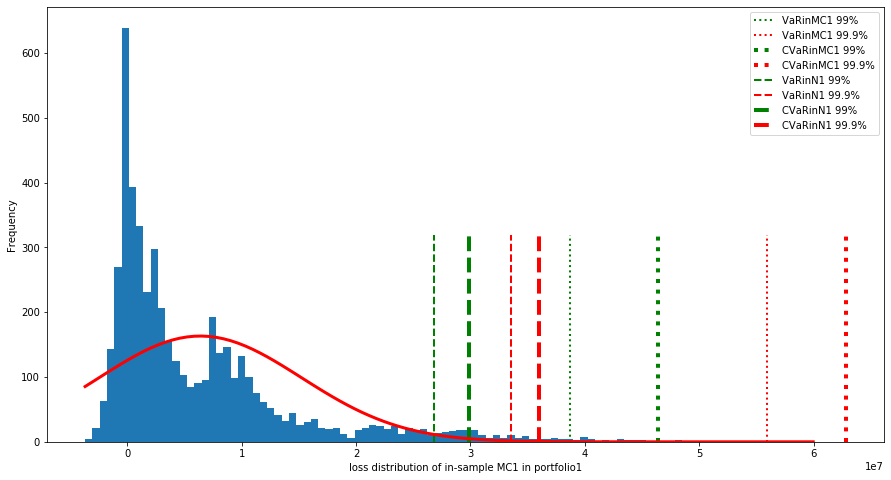

In [7]:
# Portfolio 1 in sample MC1
plt.figure(figsize=(15,8))
frequencyCounts, binLocations, patches = plt.hist(np.sort(np.dot(Losses_mc1,x0[0])), 100)
normf = (1 / (np.std(np.sort(np.dot(Losses_mc1,x0[0]))) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.sort(np.dot(Losses_mc1,x0[0])))) / np.std(np.sort(np.dot(Losses_mc1,x0[0])))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle=':')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle=':')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle=':')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle=':')
plt.plot([np.mean(VaRinN1[0,0]), np.mean(VaRinN1[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle='--')
plt.plot([np.mean(VaRinN1[0,1]), np.mean(VaRinN1[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='--')
plt.plot([np.mean(CVaRinN1[0,0]), np.mean(CVaRinN1[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle='--')
plt.plot([np.mean(CVaRinN1[0,1]), np.mean(CVaRinN1[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle='--')
plt.legend(["VaRinMC1 99%", "VaRinMC1 99.9%", "CVaRinMC1 99%", "CVaRinMC1 99.9%", "VaRinN1 99%", "VaRinN1 99.9%", "CVaRinN1 99%", "CVaRinN1 99.9%"])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('loss distribution of in-sample MC1 in portfolio1')
plt.ylabel('Frequency')
plt.draw()

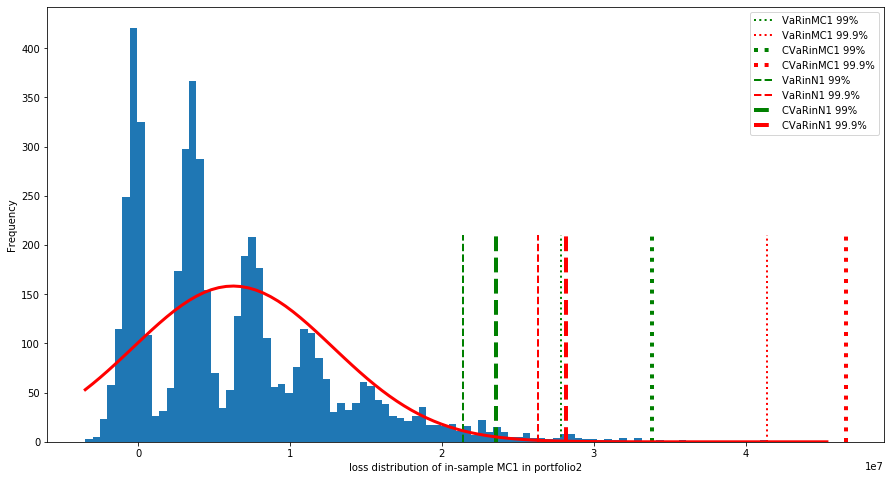

In [8]:
# Portfolio 2 in sample MC1
plt.figure(figsize=(15,8))
frequencyCounts, binLocations, patches = plt.hist(np.sort(np.dot(Losses_mc1,x0[1])), 100)
normf = (1 / (np.std(np.sort(np.dot(Losses_mc1,x0[1]))) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.sort(np.dot(Losses_mc1,x0[1])))) / np.std(np.sort(np.dot(Losses_mc1,x0[1])))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle=':')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle=':')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle=':')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle=':')
plt.plot([np.mean(VaRinN1[1,0]), np.mean(VaRinN1[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle='--')
plt.plot([np.mean(VaRinN1[1,1]), np.mean(VaRinN1[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='--')
plt.plot([np.mean(CVaRinN1[1,0]), np.mean(CVaRinN1[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle='--')
plt.plot([np.mean(CVaRinN1[1,1]), np.mean(CVaRinN1[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle='--')
plt.legend(["VaRinMC1 99%", "VaRinMC1 99.9%", "CVaRinMC1 99%", "CVaRinMC1 99.9%", "VaRinN1 99%", "VaRinN1 99.9%", "CVaRinN1 99%", "CVaRinN1 99.9%"])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('loss distribution of in-sample MC1 in portfolio2')
plt.ylabel('Frequency')
plt.draw()

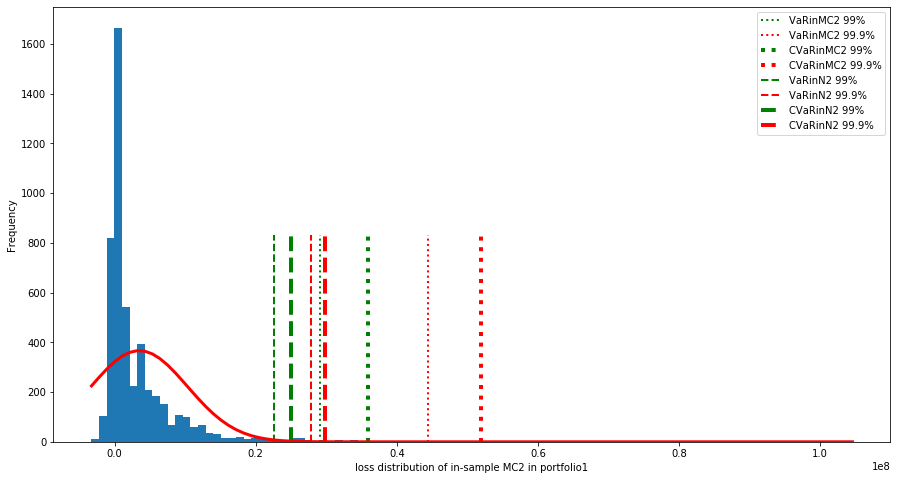

In [9]:
# Portfolio 1 in sample MC2
plt.figure(figsize=(15,8))
frequencyCounts, binLocations, patches = plt.hist(np.sort(np.dot(Losses_mc2,x0[0])), 100)
normf = (1 / (np.std(np.sort(np.dot(Losses_mc2,x0[0]))) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.sort(np.dot(Losses_mc2,x0[0])))) / np.std(np.sort(np.dot(Losses_mc2,x0[0])))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle=':')
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle=':')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle=':')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle=':')
plt.plot([np.mean(VaRinN2[0,0]), np.mean(VaRinN2[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle='--')
plt.plot([np.mean(VaRinN2[0,1]), np.mean(VaRinN2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='--')
plt.plot([np.mean(CVaRinN2[0,0]), np.mean(CVaRinN2[0,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle='--')
plt.plot([np.mean(CVaRinN2[0,1]), np.mean(CVaRinN2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle='--')
plt.legend(["VaRinMC2 99%", "VaRinMC2 99.9%", "CVaRinMC2 99%", "CVaRinMC2 99.9%", "VaRinN2 99%", "VaRinN2 99.9%", "CVaRinN2 99%", "CVaRinN2 99.9%"])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('loss distribution of in-sample MC2 in portfolio1')
plt.ylabel('Frequency')
plt.draw()

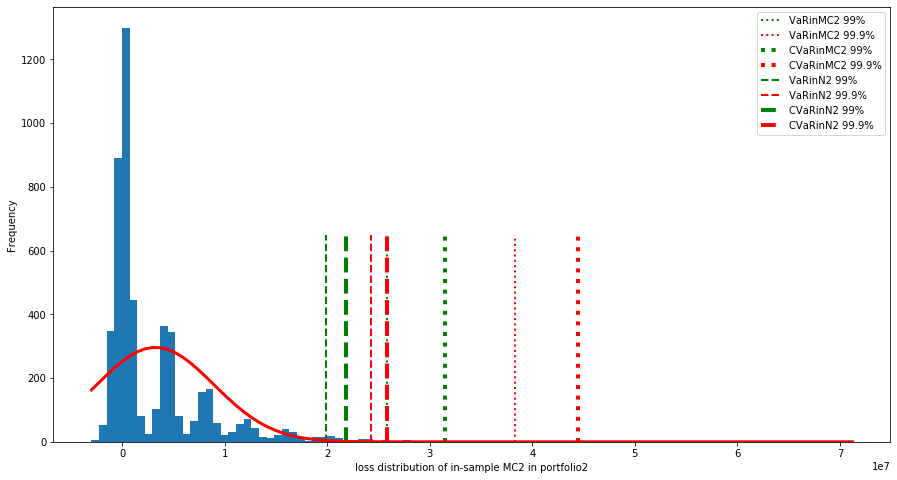

In [10]:
# Portfolio 2 in sample MC2
plt.figure(figsize=(15,8))
frequencyCounts, binLocations, patches = plt.hist(np.sort(np.dot(Losses_mc2,x0[1])), 100)
normf = (1 / (np.std(np.sort(np.dot(Losses_mc2,x0[1]))) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.sort(np.dot(Losses_mc2,x0[1])))) / np.std(np.sort(np.dot(Losses_mc2,x0[1])))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle=':')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle=':')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle=':')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle=':')
plt.plot([np.mean(VaRinN2[1,0]), np.mean(VaRinN2[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=2, linestyle='--')
plt.plot([np.mean(VaRinN2[1,1]), np.mean(VaRinN2[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='--')
plt.plot([np.mean(CVaRinN2[1,0]), np.mean(CVaRinN2[1,0])], [0, max(frequencyCounts) / 2], color='g', linewidth=4, linestyle='--')
plt.plot([np.mean(CVaRinN2[1,1]), np.mean(CVaRinN2[1,1])], [0, max(frequencyCounts)/2], color='r', linewidth=4, linestyle='--')
plt.legend(["VaRinMC2 99%", "VaRinMC2 99.9%", "CVaRinMC2 99%", "CVaRinMC2 99.9%", "VaRinN2 99%", "VaRinN2 99.9%", "CVaRinN2 99%", "CVaRinN2 99.9%"])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('loss distribution of in-sample MC2 in portfolio2')
plt.ylabel('Frequency')
plt.draw()